In [6]:
from EDA import *

In [7]:
main_data_dir = './TXT/'
# True --> run preprocessing and save the results, False --> just do the data analysis with your previously saved
    # dataframe file (always have to do a preprocessing run to save the dataframe of course)
do_preprocessing = True

if do_preprocessing:
    speeches_df = pd.DataFrame(columns=['session_nr', 'year', 'country', 'word_count', 'pos_sentiment',
                                        'neu_sentiment', 'neg_sentiment', 'average_sentence_length'])

    num_directories = len(next(os.walk(main_data_dir))[1])
    if not os.path.exists('Data/raw_speeches.csv'):

        # loop through all directories of the data
        for root, subdirectories, files in tqdm(os.walk(main_data_dir), total=num_directories, desc='directory: '):

            # remove all the files starting with '.' (files created by opening a mac directory on a windows PC,
            # so will only do something if you are working on a windows PC
            files_without_dot = [file for file in files if not file.startswith('.')]

            # loop through files and extract data
            for file in tqdm(files_without_dot, desc='files: ', leave=False):
                country, session_nr, year = file.replace('.txt', '').split('_')

                # open a speech with the correct formatting
                speech_data = open_speech(os.path.join(root, file))

                # preprocess the data
                preprocessed_bag_of_words = preprocess_speech(speech_data)

                # calculate all the features through functions
                word_count = count_total_words(preprocessed_bag_of_words)
                most_used_words = count_most_used_words(preprocessed_bag_of_words, 20)
                occs_of_spec_words = count_specific_words(preprocessed_bag_of_words, ['economy'])
                sentiment_of_speech = determine_sentiment(speech_data)
                average_sentence_length = determine_average_sentence_length(speech_data)

                # append the line of features to the dataframe
                speeches_df = speeches_df.append({'session_nr': int(session_nr),
                                                  'year': int(year),
                                                  'country':country,
                                                  'word_count':word_count,
                                                  'pos_sentiment': sentiment_of_speech['pos'],
                                                  'neu_sentiment': sentiment_of_speech['neu'],
                                                  'neg_sentiment': sentiment_of_speech['neg'],
                                                  'average_sentence_length': average_sentence_length,
                                                  'speech': remove_line_number(speech_data)
                                                  },
                                                 ignore_index=True)
        speeches_df.to_csv('Data/raw_speeches.csv', index=False)
    else:
        speeches_df = pd.read_csv('Data/raw_speeches.csv')
        
    # read in country codes and happiness data
    df_codes = pd.read_csv('Data/UNSD — Methodology.csv', delimiter=',')
    happiness_df = pd.read_excel('Data/DataPanelWHR2021C2.xls', index_col=[0, 1])

    # cleanup dataframes before merging
    speeches_df = speeches_df_cleanup(speeches_df)
    happiness_df = happiness_df_cleanup(happiness_df)
    speeches_df = speeches_df.merge(df_codes, how='left', left_on='country', right_on='ISO-alpha3 Code')

    # add the happiness data 
    
    speech_happy_merged_df = pd.merge(speeches_df, happiness_df, how='left',
                                      left_on=['year', 'Country or Area'], right_on=['year', 'Country name'])
    # speech_happi_merged_df.to_csv('preprocessed_dataframe.csv')

# interpolation for missing values in happiness df columns

def interpolate(df, col, country):
    minidf = pd.DataFrame({col : df[col].loc[:,country].interpolate(method='slinear')})
    minidf['country'] = country
    minidf = minidf.reset_index()
    minidf.set_index(['year', 'country'], inplace=True)
    return df.update(minidf)

countries = speeches_df.reset_index()['country'].unique()
cols = ['Life Ladder', 'Log GDP per capita', 'Social support',
        'Healthy life expectancy at birth', 'Freedom to make life choices',
        'Generosity', 'Perceptions of corruption', 'Positive affect', 
        'Negative affect']

def multi_interpolate(df, columns, countries):
    for country in tqdm(countries):
        for column in columns:
            try:
                interpolate(df, column, country)
            except:
                print(f"FAIL: {country} : {column}")
    return df



In [ ]:
speeches_df.set_index(['year','country'], inplace=True)
multi_interpolate(speech_happy_merged_df,cols, countries)
speech_happy_merged_df['preprocessed_speech']= speech_happy_merged_df['speech'].map(preprocess_speech)
speeches_df_lemmatize = speech_happy_merged_df.to_csv("lemmatized_speech.csv")
speeches_df_lemmatize = pd.read_csv("lemmatized_speech.csv")

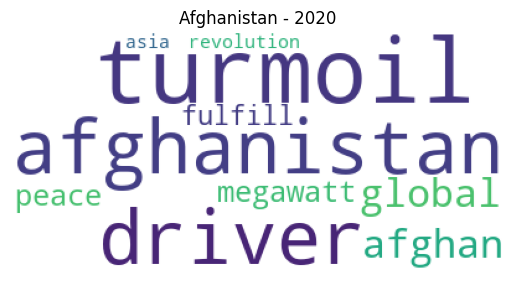

In [10]:
speeches_df_2020= speeches_df_lemmatize[speeches_df_lemmatize['year']==2020]
topnword = top10words_percountry(speeches_df_2020['preprocessed_speech'],  "tf-idf", n=10)
generate_wordcloud(topnword[0], 'Afghanistan - 2020')

In [11]:
# fig, axs = plt.subplots(2,2,  sharey=True, figsize = (13,13))
# for i, country in enumerate(['SYR', 'USA', 'NLD','VNM']):
# #     try:
#         ax = axs.flatten()[i]
#         times = np.arange(2010,2021)
#         top_per_year_country= topnwords_perspeech([speeches_df.loc[(year, country)]['speech'].values[-1] for year in times], 'tf-idf', n=100)
#         #take all speeches of a specific country
#         merged_speeches = " ".join(speeches_df.xs(country, level='country')['speech'].values)
#         top_allyears = topnwords_perspeech([merged_speeches], 'tf-idf', n=100)
#         top_allyears = [filter_common_words(top_allyears[0])]
#         score_dict = {}
#         for word in top_allyears[0][:8]:
#             indices = [100-get_index(top_per_year_country[i],word) for i in range(len(top_per_year_country))]
#             score_dict[word] = indices
#         for word in score_dict.keys():
# #             None
#             size = [0  if np.isnan(n) else n for n in score_dict[word]] 
#             ax.scatter(times, score_dict[word], label = word, s=size)
#         ax.legend()
#         ax.set_xlabel("Year")
#         ax.set_ylabel("Score")
#         ax.set_title(country)
# #     except:
#         pass
# plt.show()
    